# Capstone Project

### Project Questions
* Can we determine gender based on the words used in essay answers
* Can we determine income based off of words used in essay answers
* Can we determine education based off of words used in essay answers

In [1]:
import re, time, os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

### Here we create a function to clean up the Essay data
This essentially just removes punctuation and HTML tags from the data. 

In [3]:
def data_therapy(dataFrame):
    temp_holder = []
    dataFrame = dataFrame.replace(['<br />', '<b>', '</b>','<a.*>', '\n', '-', '[,.!"/():?_;]'],' ', regex=True)
    for i in range(len(dataFrame)):
        temp_holder.append(re.sub(' +', ' ', dataFrame[i].strip().lower()))

    return temp_holder

In [4]:
data = pd.read_csv('profiles.csv') ## Create DataFrame
#essay_data = pd.read_csv('profiles.csv')

### To make the data easier to work with later, lets create a key map for both the education and gender columns 

In [5]:
educations = data.education.replace(np.nan, 'not_set', regex=True)
educations = educations.sort_values().unique()

counter = 0
education_map = {}

for education in educations:
    education_map[education] = int(counter)
    counter += 1

data["education_code"] = data.education.map(education_map)
data = data[pd.notnull(data['education_code'])]
data["education_code"] = data.education_code.astype('int64')

education_code = data["education_code"]
educations_code = education_code.replace(np.nan, 'not_set', regex=True)

genders = data.sex.replace(np.nan, '', regex=True)
genders = genders.sort_values().unique()

counter = 0
gender_map = {}

for gender in genders:
    gender_map[gender] = counter
    counter += 1

data["gender_code"] = data.sex.map(gender_map)

In [6]:
data.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,orientation,pets,religion,sex,sign,smokes,speaks,status,education_code,gender_code
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,25,1
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,31,1
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available,12,1
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single,25,1
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single,9,1


In [7]:
col = ['gender_code', 'sex', 'education_code', 'education', 'essay0']
essay_data = data[col]
essay_data = essay_data[pd.notnull(data['essay0'])]
essay_data = essay_data[pd.notnull(data['gender_code'])]
essay_data = essay_data[pd.notnull(data['education_code'])]

essay_data.columns = col
essay_data = essay_data.reset_index(drop=True)

essay_data['essay0'] = data_therapy(essay_data['essay0'])

/home/jbard/anaconda3/envs/capstone/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jbard/anaconda3/envs/capstone/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [8]:
essay_data.head(n=10)

,gender_code,sex,education_code,education,essay0
0,1,m,25,working on college/university,about me i would love to think that i was some...
1,1,m,31,working on space camp,i am a chef this is what that means 1 i am a w...
2,1,m,12,graduated from masters program,i'm not ashamed of much but writing public tex...
3,1,m,25,working on college/university,i work in a library and go to school
4,1,m,9,graduated from college/university,hey how's it going currently vague on the prof...
5,1,m,9,graduated from college/university,i'm an australian living in san francisco but ...
6,0,f,9,graduated from college/university,life is about the little things i love to laug...
7,1,m,32,working on two-year college,my names jake i'm a creative guy and i look fo...
8,1,m,9,graduated from college/university,i was born in wisconsin grew up in iowa and mo...
9,1,m,28,working on masters program,i just moved to the bay area from austin tx or...


---

# Data Analysis

---

## Gender Analysis

In [9]:
male_count, female_count = data['sex'].value_counts()
gender_data = data['sex'].value_counts()
male_by_age = data.loc[data['sex'] == 'm'].groupby('age').count()['sex']
female_by_age = data.loc[data['sex'] == 'f'].groupby('age').count()['sex']

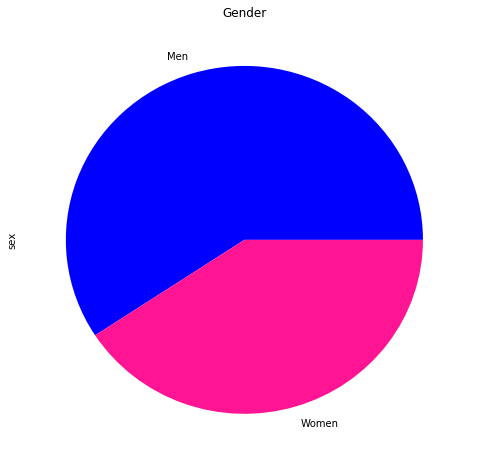

In [10]:
plt.title("Gender")
gender_data.plot.pie(labels=['Men', 'Women'], colors=['blue', '#FF1493'], figsize=(8,8))

In [11]:
objects = ('Men', 'Women')
y_pos = np.arange(len(objects))

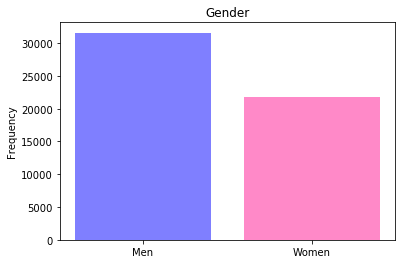

In [12]:
plt.bar(y_pos, [male_count, female_count], color=['blue','#FF1493'], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Gender')

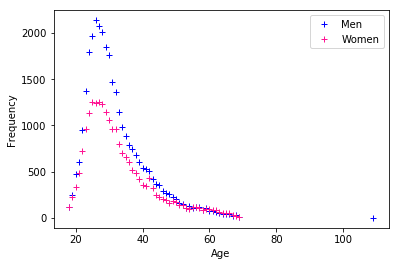

In [13]:
plt.plot(male_by_age, '+', color='blue')
plt.plot(female_by_age, '+', color='#FF1493')
plt.legend(['Men', 'Women'])
plt.xlabel('Age')
plt.ylabel('Frequency')

### Results
We can clearly see that overall, more men than women are in the data set but have also specifically narrowed down the male to female ratio based off of age. 


---


## Income Analysis

In [14]:
x_data = data['income'].sort_values().value_counts()
y_data = data['income'].value_counts().index.tolist()

y_pos = np.arange(len(y_data))
x_data

-1          42535
 20000       2795
 100000      1534
 80000       1031
 30000        965
 40000        929
 50000        902
 60000        689
 70000        665
 150000       605
 1000000      490
 250000       133
 500000        45
Name: income, dtype: int64

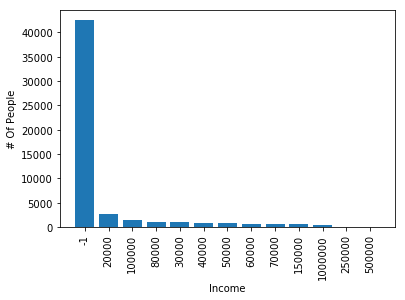

In [15]:
plt.bar(y_pos, x_data)
plt.xticks(y_pos, y_data, rotation=90)
plt.ylabel('# Of People')
plt.xlabel('Income')

### Results
After analyzing the income data, it seems that the vast majority of everyone choose to not provide their income level. These findings suggest it will likely be very difficult to create accurate predictions of individual income based off of any other metric in the data set.

---
## Education Analysis

In [16]:
education_x = data['education'].value_counts()
education_y = data['education'].value_counts().index.tolist()

education_y_pos = np.arange(len(education_y))

In [17]:
education_x

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

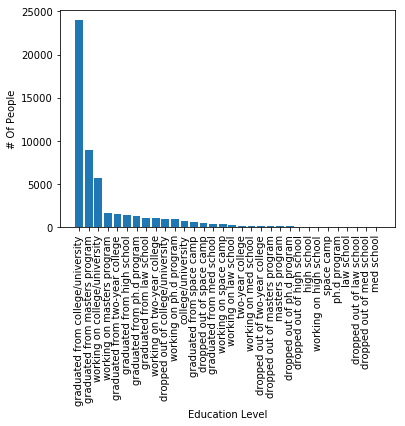

In [18]:
plt.bar(education_y_pos, education_x)
plt.xticks(education_y_pos, education_y, rotation=90)
plt.ylabel('# Of People')
plt.xlabel('Education Level')

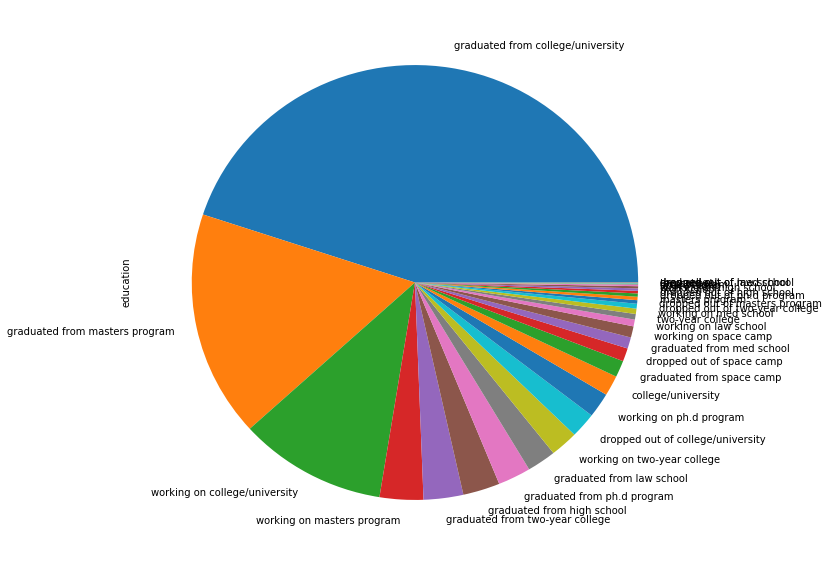

In [19]:
education_x.plot.pie(labels=education_y, figsize=(10,10))

### Results
It seems that "graduated from college/university" and "graduated from masters program" have the most data counts but there seems to be enough diversity that we can try to predict education level.


---

# Training
One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:

---

## Let's first attempt to work with our Gender data

In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(essay_data['essay0']).toarray()

In [22]:
gender_labels = essay_data['sex'].factorize()[0]
gender_id_df = essay_data[['sex', 'gender_code']].drop_duplicates().sort_values('gender_code')
gender_to_id = dict(gender_id_df.values)

education_labels = essay_data['education'].factorize()[0]
education_id_df = essay_data[['education', 'education_code']].drop_duplicates().sort_values('education_code')
education_to_id = dict(education_id_df.values)

features.shape

(48885, 87975)

In [23]:
N = 5
    
for sex, gender_code in sorted(gender_to_id.items()):
  features_chi2 = chi2(features, gender_labels == gender_code)
  indices = np.argsort(features_chi2[gender_code])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(sex))
  print("     . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("     . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print()

# 'f':
     . Most correlated unigrams:
. sassy
. gal
. love
. girl
. guy
     . Most correlated bigrams:
. nice guy
. girl loves
. going guy
. guy looking
. love laugh

# 'm':
     . Most correlated unigrams:
. frightening
. unknowns
. obstacles
. diagnose
. firing
     . Most correlated bigrams:
. haven gone
. ben jerry
. common enjoy
. likely just
. dc year



In [26]:
x_train, x_test, y_train, y_test = train_test_split(essay_data['essay0'], essay_data['sex'], random_state = 0)
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

classifier = MultinomialNB().fit(x_train_tfidf, y_train)

In [28]:
random_list_for_gender_test = [23985, 32768, 3161, 20330, 25112]

for i in random_list_for_gender_test:
    print ("Essay Response:")
    print (x_test[i])
    print ("-----------------------------")
    print ("Prediction: "+str(classifier.predict(count_vect.transform([x_test[i]]))[0]))
    print ("Actual    : "+y_test[i])
    print ()

Essay Response:
i'm an astute girl who enjoys warm and quick witted but not empty bantering individuals i happen to be a wordnerd and happen to be working on a phd in literature eww grad student i know so a good dose of humor of both the high and lowbrow sort is always welcomed in my life i like sincerity but not sentimentalism i appreciate simplicity but not smallness i like pork products some of my interests include archaic words cockney slang rhyme chicago blues cook offs sea things the open road semaphores provocative furniture the quirky and slightly offbeat i am agile prismatic and playful
-----------------------------
Prediction: f
Actual    : f

Essay Response:
after five years on the east coast i guess it's only appropriate for me to head out to the golden coast i recently joined a start up in san francisco i know super original right i'm the sixth employee and helping out with the company's marketing program it's completely different from the previous finance jobs i had in ny

In [29]:
print ("Accuracy: "+str(classifier.score(x_test_tfidf, y_test)))

Accuracy: 0.621420389462


In [25]:
N = 5
    
for education, education_code in sorted(education_to_id.items()):
    features_chi2 = chi2(features, education_labels == education_code)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(education))
    print("     . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("     . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print()

# 'college/university':
     . Most correlated unigrams:
. sfsu
. im
. studying
. majoring
. student
     . Most correlated bigrams:
. academy art
. currently student
. going school
. time student
. college student

# 'dropped out of college/university':
     . Most correlated unigrams:
. paved
. cheeseburger
. 1983
. shits
. winging
     . Most correlated bigrams:
. thought look
. went new
. hate sitting
. nice try
. wanna friends

# 'dropped out of high school':
     . Most correlated unigrams:
. master
. india
. masters
. mba
. im
     . Most correlated bigrams:
. masters degree
. got master
. master degree
. business school
. grad school

# 'dropped out of law school':
     . Most correlated unigrams:
. school
. phd
. graduated
. im
. student
     . Most correlated bigrams:
. went school
. time student
. college student
. graduated college
. grad school

# 'dropped out of masters program':
     . Most correlated unigrams:
. poppin
. wouldnt
. undecided
. revision
. im
     . Most c

In [30]:
x_train, x_test, y_train, y_test = train_test_split(essay_data['essay0'], essay_data['education'], random_state = 0)
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

classifier = MultinomialNB().fit(x_train_tfidf, y_train)

In [31]:
random_list_for_gender_test = [23985, 32768, 3161, 20330, 25112]

for i in random_list_for_gender_test:
    print ("Essay Response:")
    print (x_test[i])
    print ("-----------------------------")
    print ("Prediction: "+str(classifier.predict(count_vect.transform([x_test[i]]))[0]))
    print ("Actual    : "+y_test[i])
    print ()

Essay Response:
i'm an astute girl who enjoys warm and quick witted but not empty bantering individuals i happen to be a wordnerd and happen to be working on a phd in literature eww grad student i know so a good dose of humor of both the high and lowbrow sort is always welcomed in my life i like sincerity but not sentimentalism i appreciate simplicity but not smallness i like pork products some of my interests include archaic words cockney slang rhyme chicago blues cook offs sea things the open road semaphores provocative furniture the quirky and slightly offbeat i am agile prismatic and playful
-----------------------------
Prediction: graduated from college/university
Actual    : working on ph.d program

Essay Response:
after five years on the east coast i guess it's only appropriate for me to head out to the golden coast i recently joined a start up in san francisco i know super original right i'm the sixth employee and helping out with the company's marketing program it's completel

In [32]:
print ("Accuracy: "+str(classifier.score(x_test_tfidf, y_test)))

Accuracy: 0.453771886762
